## Imports

In [1]:
import numpy as np
from scipy import linalg, integrate
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='html5')

In [2]:
# Set font size of plot elements\n",
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Functions

In [3]:
def temp_from_photons(ω, num_photons):
    """
    function for calculating the temperature given the number of photons
    :param ω:           the frequency of the photons
    :param num_photons: the number of photons
    :returns:           the temperature
    """
    hbar_ov_k = 7.639e-12 
    return hbar_ov_k * ω / np.log(1 / num_photons + 1)

In [4]:
def photons_from_temp(ω, temp):
    """
    function for calculating the number of photons from a thermal bath
    :param ω:           the frequency of the photons
    :param temp:        the temperature of the bath
    :returns:           the number of photons
    """
    hbar_ov_k = 7.639e-12
    return (np.exp(hbar_ov_k * ω / temp) - 1) ** -1

In [5]:
def full_output_spec(ω, g, r, gy, χ, κ, γ, nT, nc, ny, Δ, Ω):
    """
    function for calculating the full output spectrum of the cavity including the YIG and NV ensemble
    :param ω:  the frequency
    :param g:  the cooperativity of the NV ensemble and the cavity
    :param r:  the damping rate of the NV ensemble
    :param gy: the cooperativity of the YIG and the cavity
    :param χ:  the damping rate of the YIG
    :param κ:  the output coupling rate
    :param γ:  the internal loss rate
    :param nT: the number of photons in the thermal bath
    :param nc: the number of photons in the cold bath (i.e. the NV ensemble)
    :param ny: the number of photons in the YIG
    :param Δ:  the cavity-spin detuning
    :param Ω:  the cavity-YIG detuning
    :returns:  the output spectrum
    """
    # Define M collect coupling rates together
    M = κ + γ

    # Numerator will be a + b + c, denominator will be d + e + f
    a = (r ** 2 / 4 + ω ** 2) * (χ ** 2 / 4 + (ω - Ω) ** 2) * κ * γ * nT
    b = g ** 2 * (χ ** 2 / 4 + (ω - Ω) ** 2) * nc * κ * r # Double check if this should have κ r
    c = gy ** 2 * (r ** 2 / 4 + ω ** 2) * ny * κ * χ # Double check if this should have κ χ
    a2 = ((κ - γ) / 2 + 1j * (ω - Δ)) * (r / 2 - 1j * ω) * (χ / 2 - 1j * (ω - Ω))
    b2 = g ** 2 * (χ / 2 - 1j * (ω - Ω))
    c2 = gy ** 2 * (r / 2 - 1j * ω)
    num = a + b + c + nT * np.abs(a2 - b2 - c2) ** 2

    d = ((κ + γ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j*ω) * (χ / 2 - 1j * (ω - Ω))
    e = g ** 2 * (χ / 2 - 1j * (ω - Ω))
    f = gy ** 2 * (r / 2 - 1j*ω)
    den = np.abs(d + e + f) ** 2

    return num / den

In [6]:
def nv_output_spec(ω, g, r, κ, γ, nT, nc, Δ):
    """
    function for calculating the full output spectrum of the cavity with just the NV ensemble.  Note: this is mostly for testing purposes
    as the full output spectrum function should yield the same thing when the YIG terms are 0
    :param ω:  the frequency
    :param g:  the cooperativity of the NV ensemble and the cavity
    :param r:  the damping rate of the NV ensemble
    :param κ:  the output coupling rate
    :param γ:  the internal loss rate
    :param nT: the number of photons in the thermal bath
    :param nc: the number of photons in the cold bath (i.e. the NV ensemble)
    :param Δ:  the cavity-spin detuning
    :returns:  the output spectrum
    """
    num = κ * r * g ** 2 * (nc - nT)
    d = (r ** 2 / 4 + ω ** 2) * ((κ + γ) ** 2 /4 + (ω - Δ) ** 2)
    e = g ** 2 * (r * (κ + γ) / 2 - 2 * ω * (ω - Δ))
    f = g ** 4
    den = d + e + f

    return nT + num / den

In [7]:
def get_polariton_freq(κ, γ, Δ, g, r, ϕ, Ω, gy, χ):
    """
    function for calculating the polariton frequencies given a set of experimental parameters
    Here we actually add an additional detuning parameter for the spin mode (r term in the matrix) compared to the notes
    This effectively means that each mode can be tuned to some reference
    :param ω:  the frequency
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param Δ:  the detuning between the NV ensemble and the cavity mode
    :param g:  the cooperativity of the NV ensemble and the cavity
    :param r:  the damping rate of the NV ensemble
    :param Ω:  the detuning between the YIG and the cavity
    :param gy: the cooperativity between the YIG and the cavity
    :param χ:  the damping rate of the YIG
    :return:   the polariton frequencies obtained by calculating the eigenvalues of the matrix in Eq. 68 in my notes
    """
    # Define the matrix
    M = np.zeros((3, 3), dtype=complex)
    temp = [
         [(κ + γ) / 2 + 1j*Δ, 1j * g, -1j * gy],
         [1j * g, r / 2 + 1j*ϕ, 0],
         [-1j * gy, 0, χ / 2 + 1j*Ω]
        ]

    # Calculate the eigenvalues
    eig = linalg.eigvals(np.array(temp))

    # return
    return np.sort(eig * 1j) * -1j

In [8]:
def full_output_spec_nv_det(ω, g, r, gy, χ, κ, γ, nT, nc, ny, Δ, ϕ, Ω):
    """
    function for calculating the full output spectrum of the cavity including the YIG and NV ensemble
    :param ω:  the frequency
    :param g:  the cooperativity of the NV ensemble and the cavity
    :param r:  the damping rate of the NV ensemble
    :param gy: the cooperativity of the YIG and the cavity
    :param χ:  the damping rate of the YIG
    :param κ:  the output coupling rate
    :param γ:  the internal loss rate
    :param nT: the number of photons in the thermal bath
    :param nc: the number of photons in the cold bath (i.e. the NV ensemble)
    :param ny: the number of photons in the YIG
    :param Δ:  the cavity detuning
    :param ϕ:  the spin detuning
    :param Ω:  the YIG detuning
    :returns:  the output spectrum
    """
    # Numerator will be a + b + c, denominator will be d + e + f
    a = (r ** 2 / 4 + (ω - ϕ) ** 2) * (χ ** 2 / 4 + (ω - Ω) ** 2) * κ * γ * nT
    b = g ** 2 * (χ ** 2 / 4 + (ω - Ω) ** 2) * nc * κ * r
    c = gy ** 2 * (r ** 2 / 4 + (ω - ϕ) ** 2) * ny * κ * χ
    a2 = ((κ - γ) / 2 + 1j * (ω - Δ)) * (r / 2 - 1j * (ω - ϕ)) * (χ / 2 - 1j * (ω - Ω))
    b2 = g ** 2 * (χ / 2 - 1j * (ω - Ω))
    c2 = gy ** 2 * (r / 2 - 1j * (ω - ϕ))
    num = a + b + c + nT * np.abs(a2 - b2 - c2) ** 2

    d = ((κ + γ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * (ω - ϕ)) * (χ / 2 - 1j * (ω - Ω))
    e = g ** 2 * (χ / 2 - 1j * (ω - Ω))
    f = gy ** 2 * (r / 2 - 1j * (ω - ϕ))
    den = np.abs(d + e + f) ** 2

    return num / den

## Tripartite Calculations

In [9]:
# Define constant parameters - we'll set the damping rates to 0 for now in case we need to check with symbolic calculations
ωc = 2 * np.pi * 2.87e9  # Hz
κ = 2 * np.pi * 185.1e3
γ = 2 * np.pi * 140e3
r = 2 * np.pi * 229e3
χ = 1e6
g = 2 * np.pi * 197.7e3
gy = 1e7

In [10]:
# Define parameters for calculating the output spectrum of the cavity
T = 5
P = 0.8
nc = 0.5 * (1 - P) / P
nT = photons_from_temp(ωc, T)

### a) $\phi \neq 0$, $\Delta = \Omega = 0$

In [11]:
# Create ranges for detuning
ϕ = np.linspace(-1, 1, 1000) * 2 * np.pi * 1e7

In [12]:
# Create arrays to store values
pol_a_freqs = np.zeros(ϕ.shape[0], dtype=complex)
pol_b_freqs = np.zeros(ϕ.shape[0], dtype=complex)
pol_c_freqs = np.zeros(ϕ.shape[0], dtype=complex)
for i in range(ϕ.shape[0]):
    temp = get_polariton_freq(κ, γ, 0, g, r, ϕ[i], 0, gy, χ)
    pol_a_freqs[i] = temp[0]
    pol_b_freqs[i] = temp[1]
    pol_c_freqs[i] = temp[2]

Text(0.5, 0, '$\\phi$ (MHz)')

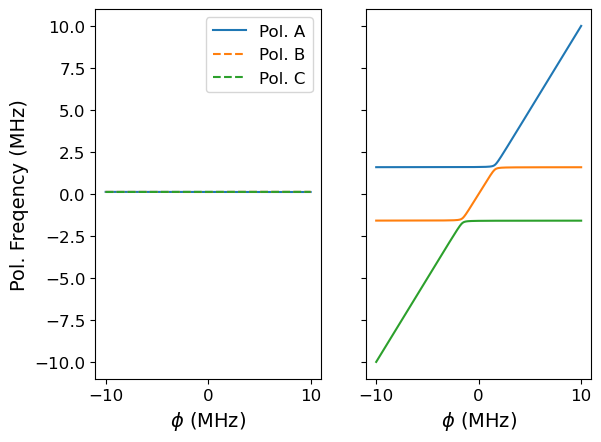

In [13]:
fig = plt.figure(1)
ax = fig.subplots(1, 2, sharey='all')
ax[0].plot(ϕ / (2 * np.pi * 1e6), pol_a_freqs.real / (2 * np.pi * 1e6), label='Pol. A')
ax[0].plot(ϕ / (2 * np.pi * 1e6), pol_b_freqs.real / (2 * np.pi * 1e6), '--', label='Pol. B')
ax[0].plot(ϕ / (2 * np.pi * 1e6), pol_c_freqs.real / (2 * np.pi * 1e6), '--', label='Pol. C')
ax[0].set_xlabel("$\\phi$ (MHz)")
ax[0].set_ylabel("Pol. Freqency (MHz)")
ax[0].legend()

ax[1].plot(ϕ / (2 * np.pi * 1e6), pol_a_freqs.imag / (2 * np.pi * 1e6), label='Pol. A')
ax[1].plot(ϕ / (2 * np.pi * 1e6), pol_b_freqs.imag / (2 * np.pi * 1e6), label='Pol. B')
ax[1].plot(ϕ / (2 * np.pi * 1e6), pol_c_freqs.imag / (2 * np.pi * 1e6), label='Pol. C')
ax[1].set_xlabel("$\\phi$ (MHz)")

In [14]:
# Calculate the spectrum
ω = np.linspace(-1, 1, 1000) * 2 * np.pi * 1e7
ωm, ϕm = np.meshgrid(ω, ϕ)

output_spec_ϕ = full_output_spec_nv_det(ωm, g, r, gy, χ, κ, γ, nT, nc, nT, 0, ϕm, 0)

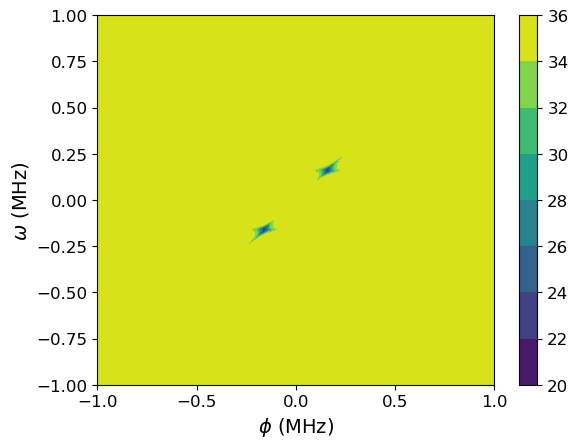

In [15]:
fig = plt.figure(1)
ax = fig.subplots(1, 1, sharey='all')
im = ax.contourf(ϕm / (2 * np.pi * 1e7), ωm / (2 * np.pi * 1e7), output_spec_ϕ)
ax.set_xlabel("$\\phi$ (MHz)")
ax.set_ylabel("$\\omega$ (MHz)")
fig.colorbar(im)

### b) $\Delta \neq 0, \Omega = \phi = 0$

In [16]:
# Create arrays to store values
pol_a_freqs = np.zeros(ϕ.shape[0], dtype=complex)
pol_b_freqs = np.zeros(ϕ.shape[0], dtype=complex)
pol_c_freqs = np.zeros(ϕ.shape[0], dtype=complex)
for i in range(ϕ.shape[0]):
    temp = get_polariton_freq(κ, γ, ϕ[i], g, r, 0, 0, gy, χ)
    pol_a_freqs[i] = temp[0]
    pol_b_freqs[i] = temp[1]
    pol_c_freqs[i] = temp[2]

Text(0.5, 0, '$\\Delta$ (MHz)')

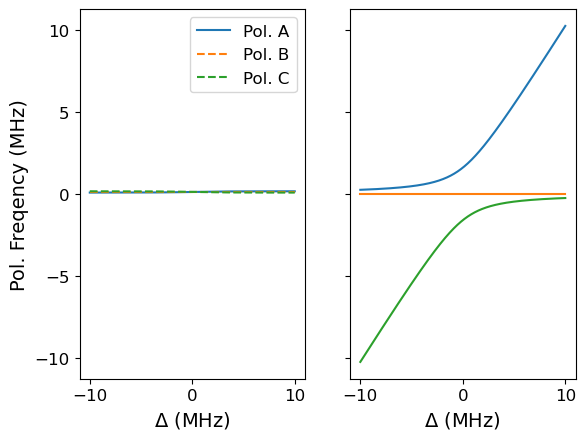

In [17]:
fig = plt.figure(1)
ax = fig.subplots(1, 2, sharey='all')
ax[0].plot(ϕ / (2 * np.pi * 1e6), pol_a_freqs.real / (2 * np.pi * 1e6), label='Pol. A')
ax[0].plot(ϕ / (2 * np.pi * 1e6), pol_b_freqs.real / (2 * np.pi * 1e6), '--', label='Pol. B')
ax[0].plot(ϕ / (2 * np.pi * 1e6), pol_c_freqs.real / (2 * np.pi * 1e6), '--', label='Pol. C')
ax[0].set_xlabel("$\\Delta$ (MHz)")
ax[0].set_ylabel("Pol. Freqency (MHz)")
ax[0].legend()

ax[1].plot(ϕ / (2 * np.pi * 1e6), pol_a_freqs.imag / (2 * np.pi * 1e6), label='Pol. A')
ax[1].plot(ϕ / (2 * np.pi * 1e6), pol_b_freqs.imag / (2 * np.pi * 1e6), label='Pol. B')
ax[1].plot(ϕ / (2 * np.pi * 1e6), pol_c_freqs.imag / (2 * np.pi * 1e6), label='Pol. C')
ax[1].set_xlabel("$\\Delta$ (MHz)")

In [18]:
# Calculate the spectrum
ω = np.linspace(-4, 4, 1000) * 2 * np.pi * 1e6
ωm, Δm = np.meshgrid(ω, ϕ)

output_spec_Δ = full_output_spec_nv_det(ωm, g, r, gy, χ, κ, γ, nT, nc, nT, Δm, 0, 0)

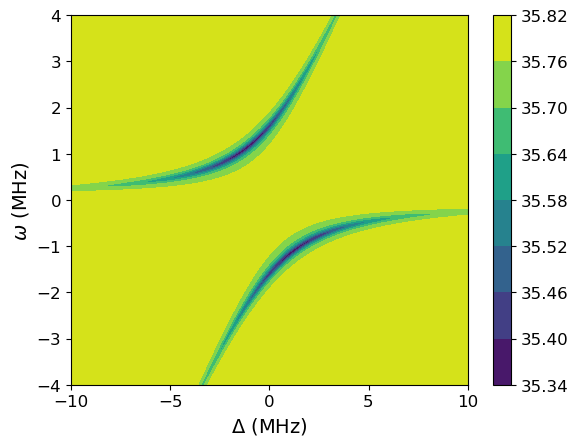

In [19]:
fig = plt.figure(1)
ax = fig.subplots(1, 1, sharey='all')
im = ax.contourf(Δm / (2 * np.pi * 1e6), ωm / (2 * np.pi * 1e6), output_spec_Δ)
ax.set_xlabel("$\\Delta$ (MHz)")
ax.set_ylabel("$\\omega$ (MHz)")
fig.colorbar(im)

### c) $\Omega \neq 0, \Delta = \phi = 0$

In [20]:
# Create arrays to store values
pol_a_freqs = np.zeros(ϕ.shape[0], dtype=complex)
pol_b_freqs = np.zeros(ϕ.shape[0], dtype=complex)
pol_c_freqs = np.zeros(ϕ.shape[0], dtype=complex)
for i in range(ϕ.shape[0]):
    temp = get_polariton_freq(κ, γ, 0, g, r, 0, ϕ[i], gy, χ)
    pol_a_freqs[i] = temp[0]
    pol_b_freqs[i] = temp[1]
    pol_c_freqs[i] = temp[2]

Text(0.5, 0, '$\\Omega$ (MHz)')

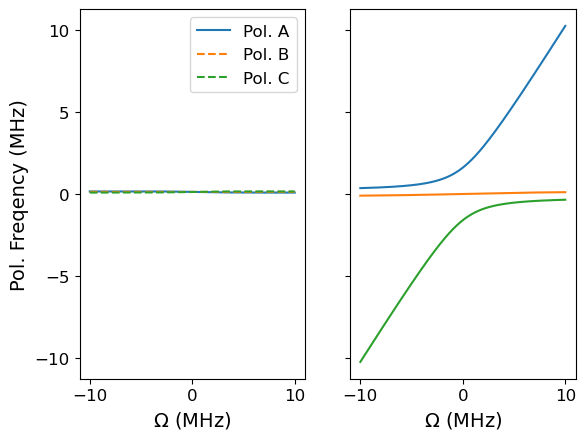

In [21]:
fig = plt.figure(1)
ax = fig.subplots(1, 2, sharey='all')
ax[0].plot(ϕ / (2 * np.pi * 1e6), pol_a_freqs.real / (2 * np.pi * 1e6), label='Pol. A')
ax[0].plot(ϕ / (2 * np.pi * 1e6), pol_b_freqs.real / (2 * np.pi * 1e6), '--', label='Pol. B')
ax[0].plot(ϕ / (2 * np.pi * 1e6), pol_c_freqs.real / (2 * np.pi * 1e6), '--', label='Pol. C')
ax[0].set_xlabel("$\\Omega$ (MHz)")
ax[0].set_ylabel("Pol. Freqency (MHz)")
ax[0].legend()

ax[1].plot(ϕ / (2 * np.pi * 1e6), pol_a_freqs.imag / (2 * np.pi * 1e6), label='Pol. A')
ax[1].plot(ϕ / (2 * np.pi * 1e6), pol_b_freqs.imag / (2 * np.pi * 1e6), label='Pol. B')
ax[1].plot(ϕ / (2 * np.pi * 1e6), pol_c_freqs.imag / (2 * np.pi * 1e6), label='Pol. C')
ax[1].set_xlabel("$\\Omega$ (MHz)")

In [22]:
# Calculate the spectrum
ω = np.linspace(-4, 4, 1000) * 2 * np.pi * 1e6
ωm, Ωm = np.meshgrid(ω, ϕ)

output_spec_Ω = full_output_spec_nv_det(ωm, g, r, gy, χ, κ, γ, nT, nc, nT, 0, 0, Ωm)

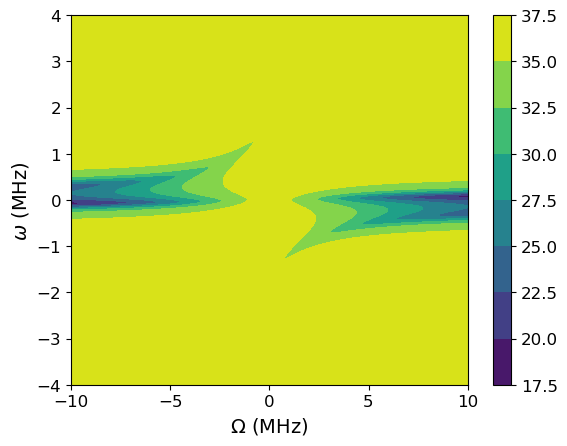

In [23]:
fig = plt.figure(1)
ax = fig.subplots(1, 1, sharey='all')
im = ax.contourf(Ωm / (2 * np.pi * 1e6), ωm / (2 * np.pi * 1e6), output_spec_Ω)
ax.set_xlabel("$\\Omega$ (MHz)")
ax.set_ylabel("$\\omega$ (MHz)")
fig.colorbar(im)

### d) Can we move the cooling spots by changing $g_y$?
We will assume that the cavity and YIG are on resonance (so $\Delta = \Omega = 0$)

In [24]:
# Want to create list of values for gy that turn it on
gy_vals = [0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]

In [25]:
# Define the other parameters
ωc = 2 * np.pi * 2.87e9  # Hz
κ = 2 * np.pi * 185.1e3
γ = 2 * np.pi * 140e3
r = 2 * np.pi * 229e3
g = 2 * np.pi * 197.7e3
χ = 1e6

# Define thermal photon numbers
T = 5
nT = photons_from_temp(ωc, T)
P = 0.8
nc = 0.5 * (1 - P) / P

In [26]:
# Perform polariton calculations - need to loop over gy values
# First define ϕ and create arrays for storage
ϕ = np.linspace(-7, 7, 1000) * 2 * np.pi * 1e6
pol_a_freqs = np.zeros((len(gy_vals), ϕ.shape[0]), dtype=complex)
pol_b_freqs = np.zeros((len(gy_vals), ϕ.shape[0]), dtype=complex)
pol_c_freqs = np.zeros((len(gy_vals), ϕ.shape[0]), dtype=complex)

# Now calculate polariton frequencies for each value of gy and store
for i in range(len(gy_vals)):
    for j in range(ϕ.shape[0]):
        temp = get_polariton_freq(κ, γ, 0, g, r, ϕ[j], 0, gy_vals[i], gy_vals[i])
        pol_a_freqs[i][j] = temp[0]
        pol_b_freqs[i][j] = temp[1]
        pol_c_freqs[i][j] = temp[2]

MovieWriter ffmpeg unavailable; using Pillow instead.


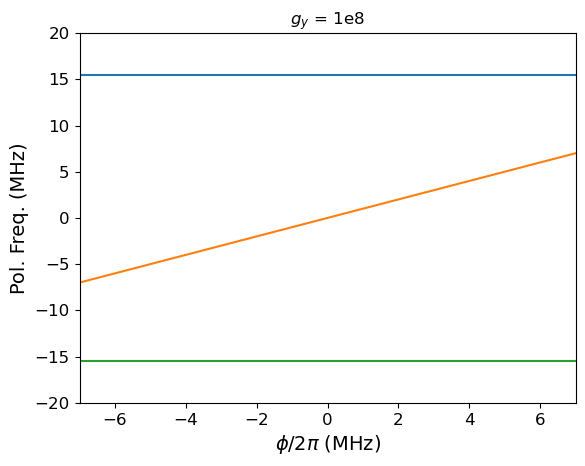

In [27]:
# Easiest to animate the progression as gy increases
# Create a figure and axis set
fig = plt.figure(1)
ax = fig.subplots(1, 1)
ax.set_ylim([-20, 20])
ax.set_xlim([ϕ[0] / (2 * np.pi * 1e6), ϕ[-1] / (2 * np.pi * 1e6)])
ax.set_ylabel("Pol. Freq. (MHz)")
ax.set_xlabel("$\\phi / 2\\pi$ (MHz)")
xdata, ydata = [], []
ln1, = ax.plot(xdata, ydata, label='Pol. A')
ln2, = ax.plot(xdata, ydata, label='Pol. B')
ln3, = ax.plot(xdata, ydata, label='Pol. C')


def anim(i):
    ln1.set_data(ϕ / (2 * np.pi * 1e6), pol_a_freqs[i].imag / (2 * np.pi * 1e6))
    ln2.set_data(ϕ / (2 * np.pi * 1e6), pol_b_freqs[i].imag / (2 * np.pi * 1e6))
    ln3.set_data(ϕ / (2 * np.pi * 1e6), pol_c_freqs[i].imag / (2 * np.pi * 1e6))
    ax.set_title("$g_y$ = 1e" + str(i))
    return ln1, ln2, ln3

ani = FuncAnimation(fig, anim, len(gy_vals), interval=500, blit=True, repeat=True)
ani.save("pol_freqs_anim.gif")

In [28]:
# Calculate the spectrum
ω = np.linspace(-7, 7, 1000) * 2 * np.pi * 1e6
ωm, ϕm = np.meshgrid(ω, ϕ)

# Set up array for storage
output_spec = np.zeros((len(gy_vals), ω.shape[0], ϕ.shape[0]), dtype=complex)

#output_spec_ϕ = full_output_spec_nv_det(ωm, g, r, gy, χ, κ, γ, nT, nc, nT, 0, ϕm, 0)

for i in range(len(gy_vals)):
    output_spec[i] = full_output_spec_nv_det(ωm, g, r, gy_vals[i], gy_vals[i], κ, γ, nT, nc, nT, 0, ϕm, 0)

/home/jacob/anaconda3/envs/mode_cooling/lib/python3.11/site-packages/matplotlib/contour.py:1568: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
/home/jacob/anaconda3/envs/mode_cooling/lib/python3.11/site-packages/matplotlib/contour.py:1569: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
/home/jacob/anaconda3/envs/mode_cooling/lib/python3.11/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


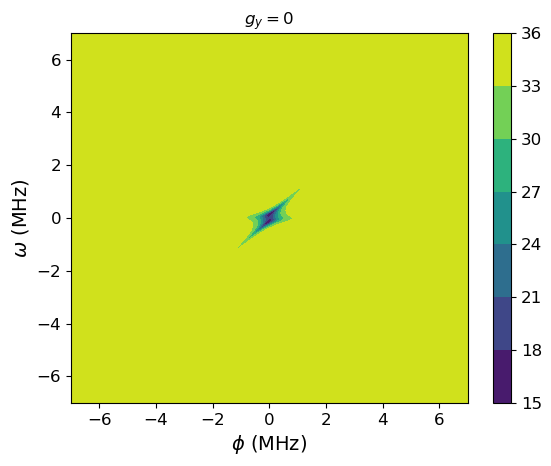

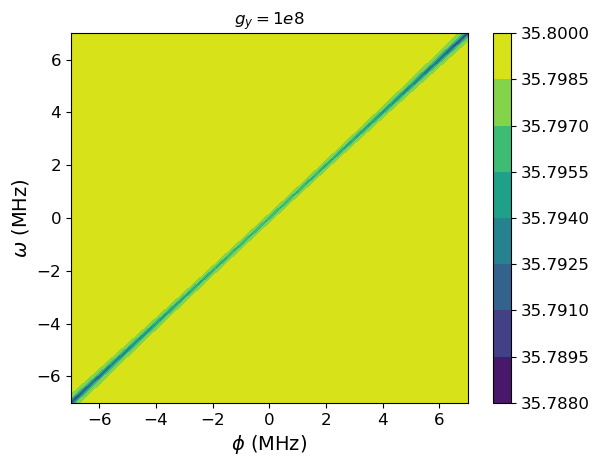

In [29]:
fig = plt.figure(1)
ax = fig.subplots(1, 1, sharey='all')
im = ax.contourf(ϕm / (2 * np.pi * 1e6), ωm / (2 * np.pi * 1e6), output_spec[0])
ax.set_xlabel("$\\phi$ (MHz)")
ax.set_ylabel("$\\omega$ (MHz)")
ax.set_title("$g_y = 0$")
fig.colorbar(im)

fig2 = plt.figure(2)
ax = fig2.subplots(1, 1, sharey='all')
im = ax.contourf(ϕm / (2 * np.pi * 1e6), ωm / (2 * np.pi * 1e6), output_spec[-1])
ax.set_xlabel("$\\phi$ (MHz)")
ax.set_ylabel("$\\omega$ (MHz)")
ax.set_title("$g_y = 1e8$")
fig2.colorbar(im)